## Import Libraries and Data

In [1]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook
#%matplotlib inline

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_0410-09-2023.csv', firstRow=804, lastRow=810)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_040923_S805-810.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)
#default t_baseline=25

## Analyse Water Addition

In [2]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=64s and ended at t=478s; mass=44.870650000000005g
This equals a volume of 44.961m; expected was 45.115mL; error is 0.343%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.001 g/s and for 2nd derivative = 0.0002 g/s^2


<IPython.core.display.Javascript object>


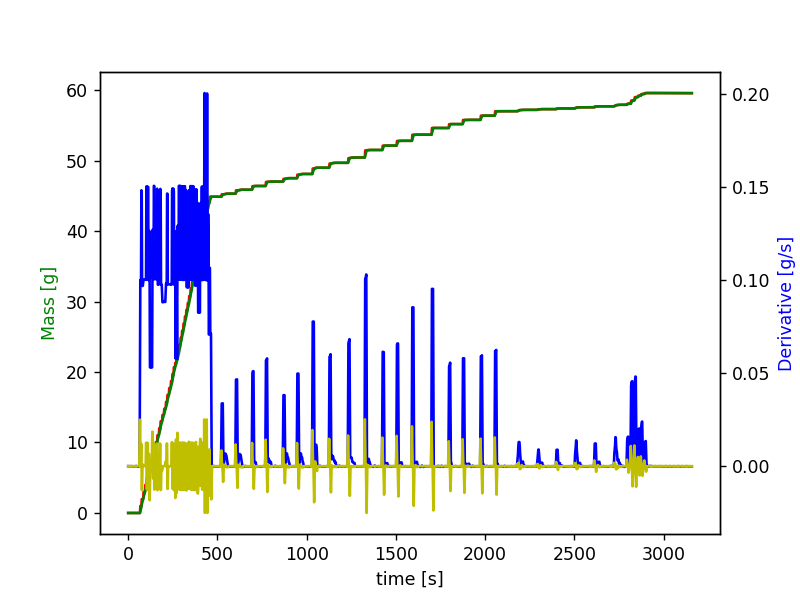

Addition of 0.437g Texapon SB 3 KC detected from 518s to 564s - expected volume = 0.556mL and actual volume = 0.394mL (resulting error is 29.173%)
Addition of 0.567g Texapon SB 3 KC detected from 598s to 644s - expected volume = 0.556mL and actual volume = 0.51mL (resulting error is 8.152%)
Addition of 0.533g Plantapon ACG 50 detected from 690s to 722s - expected volume = 0.519mL and actual volume = 0.474mL (resulting error is 8.689%)
Addition of 0.629g Plantapon ACG 50 detected from 766s to 808s - expected volume = 0.519mL and actual volume = 0.56mL (resulting error is 7.866%)
Addition of 0.483g Plantapon LC 7 detected from 864s to 910s - expected volume = 0.615mL and actual volume = 0.459mL (resulting error is 25.443%)
Addition of 0.601g Plantapon LC 7 detected from 942s to 988s - expected volume = 0.615mL and actual volume = 0.57mL (resulting error is 7.34%)
Addition of 0.892g Plantapon LC 7 detected from 1028s to 1064s - expected volume = 0.956mL and actual volume = 0.85mL (resulti

In [3]:
# default: bl_mult=5, mergeSens=10
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

#t2 = massProfile.defineIngredientsManually(specType='surfactant',steps=steps,show=True,manualTimes=[560,600,700,800,900,1000,1100,1150,1250,1320,1400,1500,1580,1650,1730,1830,1920,2000,2080,2140])

## Analyse Polyelectrolytes

Peak threshold for 1st derivative = 0.00125 g/s and for 2nd derivative = 0.00025 g/s^2


<IPython.core.display.Javascript object>


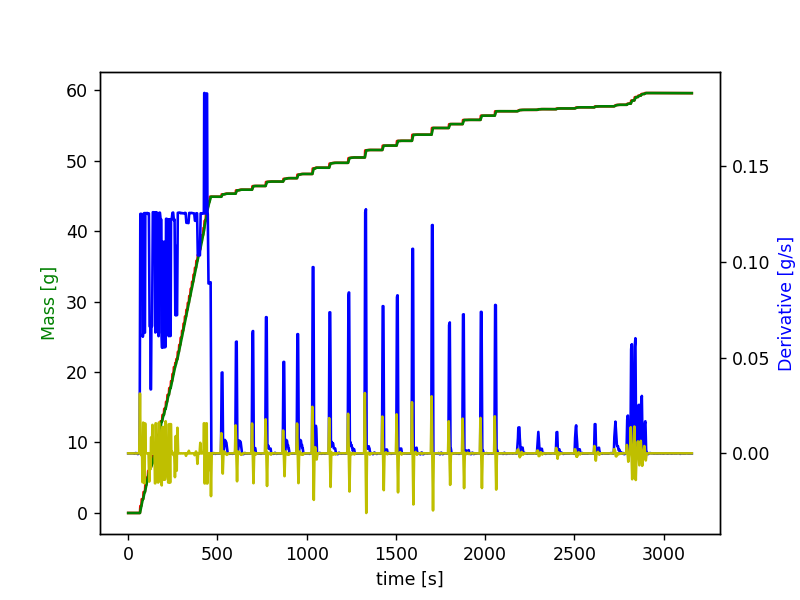

Addition of 0.197g Dehyquart CC7 Benz detected from 2176s to 2218s - expected volume = 0.199mL and actual volume = 0.195mL (resulting error is 1.866%)
Addition of 0.105g Dehyquart CC7 Benz detected from 2288s to 2326s - expected volume = 0.099mL and actual volume = 0.104mL (resulting error is 5.5%)
Addition of 0.105g Dehyquart CC7 Benz detected from 2394s to 2422s - expected volume = 0.102mL and actual volume = 0.102mL (resulting error is 0.721%)
Addition of 0.162g Dehyquart CC7 Benz detected from 2498s to 2538s - expected volume = 0.161mL and actual volume = 0.16mL (resulting error is 0.767%)
Addition of 0.143g Dehyquart CC7 Benz detected from 2608s to 2646s - expected volume = 0.136mL and actual volume = 0.143mL (resulting error is 4.745%)
Addition of 0.225g Dehyquart CC7 Benz detected from 2718s to 2758s - expected volume = 0.216mL and actual volume = 0.223mL (resulting error is 3.154%)


In [4]:
# default bl_mult = 5, default mergeSens = 5
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=5, mergeSens=5, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

#t3 = massProfile.defineIngredientsManually(specType='polyelectrolyte',steps=steps,show=True,manualTimes=[2152,2256,2366,2482,2582,2680,2758])

## Analyse Thickeners

Peak threshold for 1st derivative = 0.005 g/s and for 2nd derivative = 0.001 g/s^2


<IPython.core.display.Javascript object>


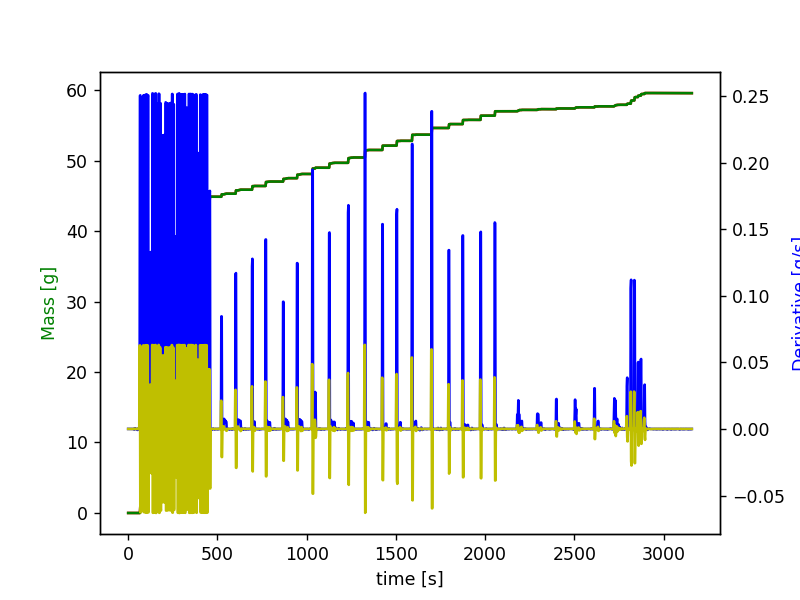

Addition of 0.159g Arlypon TT detected from 2790s to 2804s - expected volume = 0.188mL and actual volume = 0.166mL (resulting error is 11.667%)
Addition of 0.456g Arlypon TT detected from 2812s to 2826s - expected volume = 0.515mL and actual volume = 0.476mL (resulting error is 7.591%)
Addition of 0.48g Arlypon TT detected from 2832s to 2848s - expected volume = 0.464mL and actual volume = 0.496mL (resulting error is 7.016%)
Addition of 0.2g Arlypon TT detected from 2852s to 2864s - expected volume = 0.138mL and actual volume = 0.208mL (resulting error is 50.376%)
Addition of 0.238g Arlypon TT detected from 2868s to 2884s - expected volume = 0.212mL and actual volume = 0.25mL (resulting error is 17.822%)
Addition of 0.136g Arlypon TT detected from 2888s to 2902s - expected volume = 0.106mL and actual volume = 0.142mL (resulting error is 34.653%)


In [5]:
# default bl_mult = 1, default mergeSens = 1
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=1, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

#t4 = massProfile.defineIngredientsManually(specType='thickener',steps=steps,show=True,manualTimes=[2760,2780,2800,2538,2554,2568,2588])

## Consolidate results and create output

In [6]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_040923_S805-S810.csv', index=False)
actualMassFractions

C:\Users\ACHI01\AppData\Local\Temp\ipykernel_32320\2097732660.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for entry in sampleList[i].addedMassSeries.iteritems():


,ID,Texapon SB 3 KC,Plantapon ACG 50,Plantapon LC 7,Plantacare 818,Plantacare 2000,Dehyton MC,Dehyton PK 45,Dehyton ML,Dehyton AB 30,Plantapon Amino SCG-L,Plantapon Amino KG-L,Dehyquart A-CA,Luviquat Excellence,Dehyquart CC6,Dehyquart CC7 Benz,Salcare Super 7,Arlypon F,Arlypon TT
804,805.0,0.000000,0.000000,10.943259,0.000000,0.000000,0.0,13.202753,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.990555,0.0,0.0,1.604554
805,806.0,0.000000,0.000000,0.000000,0.000000,7.593394,0.0,8.783179,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.056585,0.0,0.0,4.571860
806,807.0,0.000000,0.000000,0.000000,0.000000,10.624107,0.0,0.000000,0.0,0.000000,0.0,0.000000,12.253315,0.0,0.0,1.039973,0.0,0.0,4.770473
807,808.0,0.000000,0.000000,0.000000,7.030596,0.000000,0.0,0.000000,0.0,9.574581,0.0,0.000000,0.000000,0.0,0.0,1.623874,0.0,0.0,2.007881
808,809.0,0.000000,11.498052,8.822890,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.419696,0.0,0.0,2.354617
809,810.0,10.053106,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,11.638647,0.000000,0.0,0.0,2.252359,0.0,0.0,1.362182
